# Data
------------

In [37]:
from nera.data import DataAcquisition
from nera.data import DataTransformation
from nera.data import FROM_CSV
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

%matplotlib inline

## 1 Data transformation

| Element of graph |                                                                   Usage in our case                                                                   | 
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------:| 
| Nodes            |                                                                         Teams                                                                         | 
| Nodes Features   | altogether home wins, home losses, away win and away losses, all points scored by team, all points lost to another team until the end of the snapshot | 
| Edges            |                                                           Matches between individual teams                                                            | 
| Edge features    |                                           0 - home win, 1 - draw, 2 - away win => match outcome prediction                                            |
| Node labels      |                                                               individual teams ranking                                                                |


What type of graph do we have? - Number of vertices in our graphs is static - it is the number of all teams that we want to train on. Number of edges changes over time. Edges represent matches. So the graph is dynamic. Some vertices may not be connected in each graph snapshot, because there may be season, in which a team may not have played any match within selected league. Although this will create a redundancy in our feature matrix, it is more straightforward to implement, than reindexing teams in each snapshot in order to incorporate only those vertices with edges. So we are dealing with so called 'Dynamic graph temporal signal'.

2024-05-10 15:01:57.493 | INFO     | nera.data._data_saving_loading:load_data_csv:78 - 21100 rows loaded from ../resources/european_leagues_basketball.csv


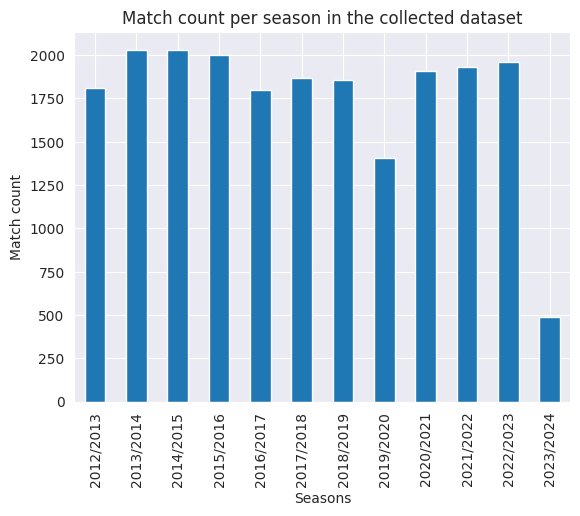

In [39]:
da = DataAcquisition()
df = da.get_data(FROM_CSV, fname="../resources/european_leagues_basketball.csv")

# see how many matches occupy each graph snapshot
df['DT'] = pd.to_datetime(df['DT'], format="%Y-%m-%d %H:%M:%S")

distinct_years = df['league_years'].value_counts().sort_index()

# Create a bar plot
distinct_years.plot(kind='bar')

# Add labels and title
plt.xlabel('Seasons')
plt.ylabel('Match count')
plt.title('Match count per season in the collected dataset')
plt.grid(True)
# Show plot
plt.show()

    

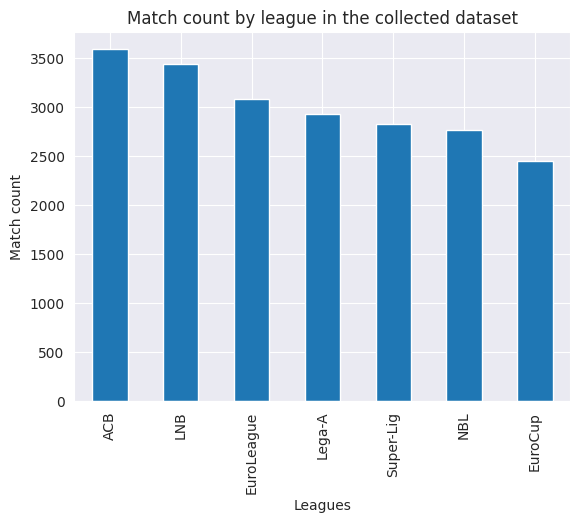

2012-09-25 18:00:00 2024-11-14 20:45:00


In [40]:
distinct_counts = df['League'].value_counts()

# Create a bar plot
distinct_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Leagues')
plt.ylabel('Match count')
plt.title('Match count by league in the collected dataset')
plt.grid(True)
# Show plot
plt.show()

print(min(df['DT']), max(df['DT']))

We can see that in each snapshot (representing 1 year), there are about 1800 matches in selected leagues altogether. That should be enough information for the graph neural network to learn from. But we need to try that first. We can also see some weird behaviour in the last two snapshots. Let's just ignore them for now and get better dataset later.

In [4]:
start_date = min(df['DT'])
df = df[(df['DT'] < start_date + 10 * delta)]
end_date = max(df['DT'])

snapshots = []

while start_date <= end_date:
    snapshots.append(df[((start_date + delta >= df['DT']) & (start_date <= df['DT']))].shape[0])
    start_date += delta
    
sns.barplot(x="index", y="matches per season", data=pd.DataFrame(snapshots, columns=["matches_in_snapshot"]).reset_index())

NameError: name 'delta' is not defined


Normally methods showcased bellow are called from data_transform.transform() method, but in our case we want to see how they work


In [6]:
# constructor of DataTransformation class drops columns that are not used by our models
data_transform = DataTransformation(df, timedelta(365))

data_transform.df.head(10)

,League,DT,Home,Away,Winner,Home_points,Away_points
0,NBL,2023-11-12 17:00:00,Srsni Pisek,Slavia Prague,away,104,69
1,NBL,2023-11-11 17:45:00,Kolin,Usti n. Labem,home,112,108
2,NBL,2023-11-11 17:30:00,Pardubice,Decin,away,64,99
3,NBL,2023-11-11 17:00:00,Opava,NH Ostrava,home,80,75
4,NBL,2023-11-11 15:30:00,Brno,USK Prague,home,75,63
5,NBL,2023-11-11 15:00:00,Nymburk,Olomoucko,home,95,71
6,NBL,2023-11-08 17:30:00,Pardubice,Opava,home,91,103
7,NBL,2023-11-04 20:00:00,Opava,Decin,away,116,91
8,NBL,2023-11-04 20:00:00,Slavia Prague,Brno,away,76,80
9,NBL,2023-11-04 18:00:00,Olomoucko,Srsni Pisek,away,81,98


### 1.1 map teams to unique ids and match outcomes to integer values

| Winner | Integer value in table | 
|:-------|:----------------------:|
| Home   |           2            | 
| Away   |           0            | 
| Draw   |           1            | 

In [7]:
data_transform._create_teams_mapping()
data_transform._map_match_outcomes(verbose=True)
data_transform.df.head(10)

TypeError: DataTransformation._map_match_outcomes() missing 1 required positional argument: 'drop_draws'

### 1.2 Extract node features (Optional, may not be needed)

recall that these are:

| Feature id     |     0     |     1      |      2      |    3     |     4      |      5      | 
|:---------------|:---------:|:----------:|:-----------:|:--------:|:----------:|:-----------:|
| Nodes Features | home wins | home draws | home losses | away win | away draws | away losses | 

All of these features are dynamic - they accumulate over time during snapshots. In our models we want to try to predict with and without those features

NOTE: The features are normalized between 0 and 1.

In [ ]:
node_features = data_transform._extract_node_features(discount_factor=0.75, use_draws=True, verbose=False)

print("Number of snapshots (league years):", len(node_features))
print(f"In each snapshot there are {node_features[0].shape[0]} nodes (teams) with {node_features[0].shape[1]} features")
node_features[-1][:5]

### 1.3 Create Edges and extract their features; Extract labels

There is just one edge feature: winner of the mathc (0 - home, 1 - draw, 2 - away). In order to predict outcomes, later, we can encode this in a one-hot representation or normalize it.

meaning: 

|      Edge feature      | home win  |   draw    | away win  | 
|:----------------------:|:---------:|:---------:|:---------:|
|     dataset value      |     2     |     1     |     0     |
|    normalized value    |     1     |    0.5    |     0     |
| one-hot representation | (0, 0, 1) | (0, 1, 0) | (1, 0, 0) |

node labels = ranking of the teams. 
We will simply compute labels for each time step. For simplicity, team with the most wins has rank 1 in each league in dataset.
NOTE labels from step n+1 are targets for step n.
We will also normalize those labels 

In [8]:
edges, edge_features, labels, points = data_transform._extract_dynamic_edges_and_labels(one_hot=True)

edges[0], edge_features[0], labels[0], points[0],edge_features[0].shape, edges[0].shape, labels[0].shape, points[0].shape

ValueError: invalid literal for int() with base 10: 'home'

### 1.5 Creating graph representation for Pytorch geometric temporal

now we have everything we need to create our dynamic graph

In [ ]:
i = 5
print(f"""Example of graph snapshot {i}: 
      Node feature shape: {node_features[i].shape} 
      Edge index shape: {edges[i].shape} 
      Edge feature shape: {edge_features[i].shape} 
      Labels shape: {labels[i].shape},
      Match_points: {points[i].shape}
      """)

In [9]:
# finally we can create our dataset iterator
from torch_geometric_temporal import DynamicGraphTemporalSignal

dataset = DynamicGraphTemporalSignal(
    edges, edge_features, node_features, labels
)
print(dataset.snapshot_count)

NameError: name 'edges' is not defined

### 1.6 All of this is done by get_dataset() method of DataTransformation

In [10]:
df = df[(df['League'] != 'EuroLeague') & (df['League'] != 'EuroCup')] 
df = df.reset_index()

transform = DataTransformation(df, timedelta(365))
dataset = transform.get_dataset(node_f_extract=False, edge_f_one_hot=True)

print(dataset.snapshot_count)

13


## Soccer and American Football datasets


In [55]:
df_premier = da.get_data(FROM_CSV, fname="../resources/Premier_League_England.csv")
df_nfl = da.get_data(FROM_CSV, fname="../resources/NFL_USA.csv")

def unify_df(data: pd.DataFrame) -> pd.DataFrame:
    data['Time'].str.replace(r'\s*AOT', '', regex=True)
    data['DT'] = pd.to_datetime(data['Time'], format='%d.%m. %H:%M', exact=False)
    
    data['Away_points'] = None
    data['Home_points'] = None
    data['Winner'] = None
    
    for iii in range(len(data)):
        month = str(data['DT'].iloc[iii].month)
        day = str(data['DT'].iloc[iii].day)
        hour = str(data['DT'].iloc[iii].hour)
        minute = str(data['DT'].iloc[iii].minute)
        if int(month) >= 6:
            year = data['Season'].iloc[iii][:4]
        else:
            year = data['Season'].iloc[iii][5:]
        data['DT'].iloc[iii] = year + '-' + month.zfill(2) + '-' + day.zfill(2) + ' ' + hour.zfill(2) + ':' + minute.zfill(2) + ':00'
        
        
        home_pts, away_pts = map(int, data['Result'].iloc[iii].split("-"))
        data['Away_points'].iloc[iii] = away_pts
        data['Home_points'].iloc[iii] = home_pts
        
        data['Winner'].iloc[iii] = 'home' if home_pts > away_pts else 'away' if away_pts > home_pts else 'draw'
        
        
    data['DT'] = pd.to_datetime(data['DT'], format='%y-%m-%d %H:%M:%S')
    
    return data.reset_index()
    
#df_premier = unify_df(df_premier)
#df_nfl = unify_df(df_nfl)  

#df_premier.to_csv("../resources/Premier_League_England.csv", index=False)
#df_nfl.to_csv("../resources/NFL_USA.csv", index=False)

print("premier:", min(df_premier['DT']), max(df_premier['DT']), len(df_premier))
print("nfl:", min(df_nfl['DT']), max(df_nfl['DT']), len(df_nfl))

2024-05-10 15:35:21.897 | INFO     | nera.data._data_saving_loading:load_data_csv:78 - 4220 rows loaded from ../resources/Premier_League_England.csv
2024-05-10 15:35:21.955 | INFO     | nera.data._data_saving_loading:load_data_csv:78 - 7921 rows loaded from ../resources/NFL_USA.csv


premier: 2008-08-16 11:45:00 2019-09-01 15:30:00 4220
nfl: 2008-09-04 23:00:00 2021-08-30 02:00:00 7921


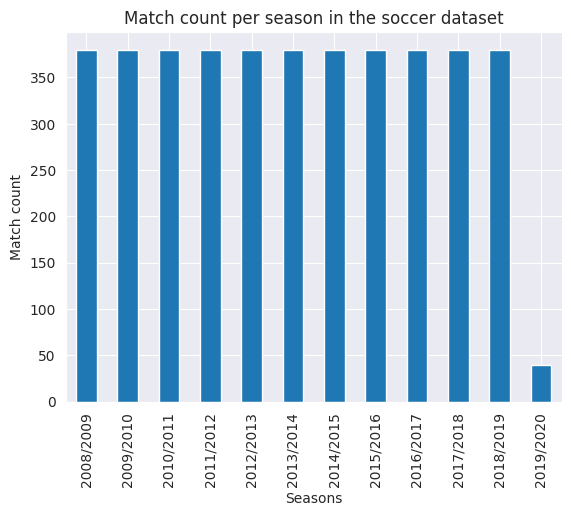

In [56]:

distinct_years = df_premier['Season'].value_counts().sort_index()

# Create a bar plot
distinct_years.plot(kind='bar')

# Add labels and title
plt.xlabel('Seasons')
plt.ylabel('Match count')
plt.title('Match count per season in the soccer dataset')
plt.grid(True)
# Show plot
plt.show()

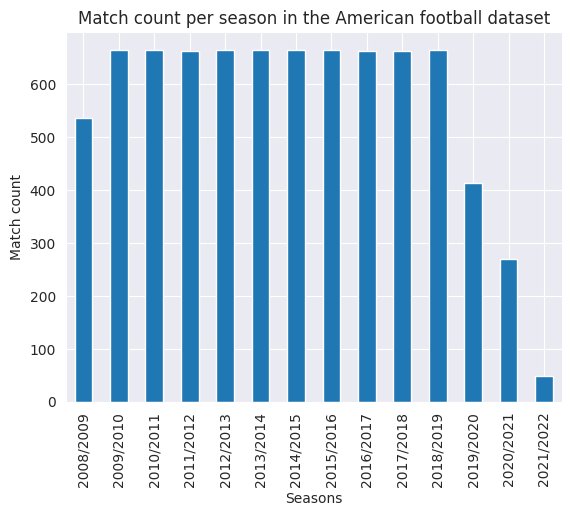

In [57]:
distinct_years = df_nfl['Season'].value_counts().sort_index()

# Create a bar plot
distinct_years.plot(kind='bar')

# Add labels and title
plt.xlabel('Seasons')
plt.ylabel('Match count')
plt.title('Match count per season in the American football dataset')
plt.grid(True)
# Show plot
plt.show()